# Overview of the training process

In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import time
import os
import pickle
from PIL import Image

def load_photos(img_dir='photos_3_scaled'):
    imgs = []
    for fp in os.listdir(img_dir):
        imgs.append(Image.open(os.path.join(img_dir, fp)))
    
    # Return as floats between 0 and 1
    return (np.asarray(imgs) / 255.).astype('float32')

train_images = load_photos()
test_images = train_images.copy()

train_size = 228
batch_size = 19
test_size = 228

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                #  .shuffle(train_size)
                 .batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                # .shuffle(test_size)
                .batch(batch_size))

def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))
    fig.suptitle(f'epoch {epoch}')

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i], cmap='gray')
        plt.axis('off')
    
    plt.savefig('epoch_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    # return fig


num_examples_to_generate = 16

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [3]:
train_images.shape

(228, 256, 256, 3)

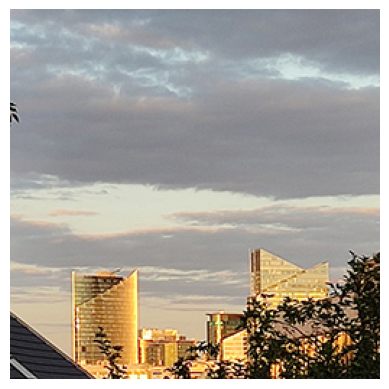

In [4]:
plt.axis('off')
plt.imshow(train_images[0], cmap='gray')

# Defining the model architecture
Run only one of the two cells below: Upsampling & Convolution creates less artifacts but is notoriously blurier than Transposed Convolution.

#### Upsampling & Convolution

In [2]:
@tf.keras.utils.register_keras_serializable()
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim=9, **kwargs):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=128, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=256, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=16 * 16 * 256, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(16, 16, 256)),
                tf.keras.layers.UpSampling2D(size=(2, 2)),
                tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
                tf.keras.layers.UpSampling2D(size=(2, 2)),
                tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
                tf.keras.layers.UpSampling2D(size=(2, 2)),
                tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
                tf.keras.layers.UpSampling2D(size=(2, 2)),
                tf.keras.layers.Conv2D(filters=3, kernel_size=3, padding='same'),
            ]
        )
    
    def save_to_file(self, fp='model_1.pickle'):
        with open('models/' + fp, 'wb') as f:
            pickle.dump(self, f)
        print('\nFile saved as', fp, '\n')

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

optimizer = tf.keras.optimizers.Adam(1e-3)

@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss."""
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

epochs = 60
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 9

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

c:\Users\Huraqan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


#### Transposed Convolution (or Deconvolution)

In [2]:
@tf.keras.utils.register_keras_serializable()
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim=9, **kwargs):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=128, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=256, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=16 * 16 * 256, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(16, 16, 256)),
                tf.keras.layers.Conv2DTranspose(
                    filters=128, kernel_size=3, strides=2, padding='same',activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=2, padding='same'),
            ]
        )
        
    def save_to_file(self, fp='model_1.pickle'):
        with open('models/' + fp, 'wb') as f:
            pickle.dump(self, f)
        print('\nFile saved as', fp, '\n')

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

optimizer = tf.keras.optimizers.Adam(1e-3)

@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss."""
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

epochs = 60
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 9

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

c:\Users\Huraqan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


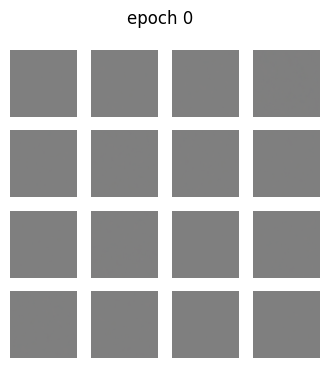

In [3]:
generate_and_save_images(model, 0, test_sample)

# TRAINING

In [ ]:
for epoch in range(1, epochs + 1):
    t = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    t = time.time() - t

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    
    display.clear_output(wait=False)
    print(f'Epoch: {epoch}, Test set ELBO: {elbo}, time elapse for current epoch: {t}')
    generate_and_save_images(model, epoch, test_sample)

# SAVING & LOADING MODEL (CUSTOM)

In [ ]:
model_name = 'model_2'

In [19]:
model.save_to_file(f'{model_name}.pickle')


File saved as model_3.pickle 



In [21]:
def load_from_file(fp=f'{model_name}.pickle'):
    with open('models/' + fp, 'rb') as f:
        return pickle.load(f)

loaded_model = load_from_file()

# SAVING & LOADING MODEL (KERAS)

In [51]:
model.save('models/model_1.keras')

c:\Users\Huraqan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


In [52]:
loaded_model = tf.keras.models.load_model('models/model_1.keras', custom_objects={'CVAE': CVAE})

# MAKE GIF

In [10]:
import glob
import imageio

def make_gif(fp_in='*.png', fp_out='epoch_results.gif'):
    with imageio.get_writer(fp_out, mode='I') as writer:
        filenames = glob.glob(fp_in)
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [18]:
make_gif('epoch_images/image_at_epoch_*.png', f'{model_name}_epochs_{epochs}.gif')

C:\Users\Huraqan\AppData\Local\Temp\ipykernel_2308\3383540804.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\Huraqan\AppData\Local\Temp\ipykernel_2308\3383540804.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


# EXPLORING THE LATENT SPACE

In [53]:
def plot_latent_image(ai=0, bi=0, ci=0, di=0, ei=0, fi=0, gi=0, hi=0, ji=0):
    z = np.array([[ai, bi, ci, di, ei, fi, gi, hi, ji]])
    x_decoded = model.sample(z)
    img = tf.reshape(x_decoded[0], (256, 256, 3)).numpy()
    return Image.fromarray((img * 255).astype(np.uint8))

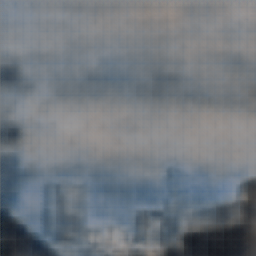

In [372]:
plot_latent_image(
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0
)